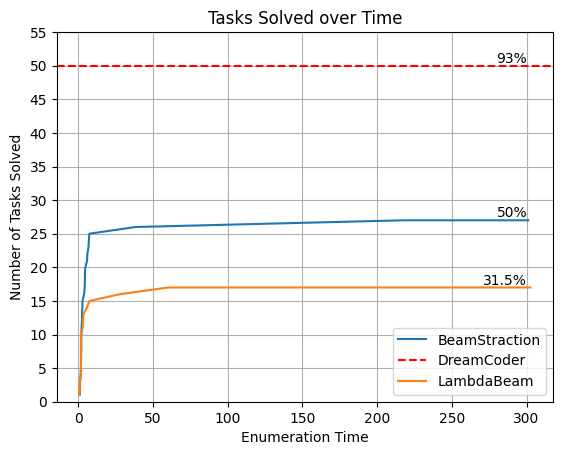

In [16]:
import matplotlib.pyplot as plt
import json

with open("/work/ldierkes/repos/new/LambdaBeam/outputs/beamstract/top/eval/results.json") as f:
    results = json.load(f)

results = results["results"]
success = []
weight = []
elapsed_time = []
for sol in results:
    elapsed_time.append(sol["elapsed_time"])
    success.append(sol["success"])
    weight.append(sol["solution_weight"])  


# Sort the data based on time taken
sorted_data = sorted(zip(elapsed_time, success))

# Separate the sorted data back into separate lists
sorted_time_taken, sorted_tasks_solved = zip(*sorted_data)

# Calculate cumulative sum of tasks solved
cumulative_tasks = [sum(sorted_tasks_solved[:i+1]) for i in range(len(sorted_tasks_solved))]


with open("/work/ldierkes/repos/new/LambdaBeam/outputs/baseline/eval/results.json") as f:
    results = json.load(f)

results = results["results"]
success = []
weight = []
elapsed_time = []
for sol in results:
    elapsed_time.append(sol["elapsed_time"])
    success.append(sol["success"])
    weight.append(sol["solution_weight"])  

# Sort the data based on time taken
sorted_data_baseline = sorted(zip(elapsed_time, success))

# Separate the sorted data back into separate lists
sorted_time_taken_baseline, sorted_tasks_solved_baseline = zip(*sorted_data_baseline)

# Calculate cumulative sum of tasks solved
cumulative_tasks_baseline = [sum(sorted_tasks_solved_baseline[:i+1]) for i in range(len(sorted_tasks_solved_baseline))]

# Plotting without markers and with legend for "BeamStraction"
plt.plot(sorted_time_taken, cumulative_tasks, linestyle='-', label='BeamStraction')
plt.axhline(y=50, color='r', linestyle='--', label='DreamCoder')
plt.plot(sorted_time_taken_baseline, cumulative_tasks_baseline, linestyle='-', label='LambdaBeam')


# Set y-axis maximum label to 54
plt.ylim(0, 54)
plt.yticks(range(0, 56, 5))
# Finding the time and tasks solved at the 50% success rate
halfway_index = int(0.5 * len(cumulative_tasks))
halfway_time = sorted_time_taken[halfway_index]
halfway_tasks = cumulative_tasks[halfway_index]

# Adding a text annotation for 50% success rate
plt.text(halfway_time, halfway_tasks, '50%', ha='right', va='bottom')
plt.text(300, 50, '93%', ha='right', va='bottom')
plt.text(300, 17, '31.5%', ha='right', va='bottom')


plt.xlabel('Enumeration Time')
plt.ylabel('Number of Tasks Solved')
plt.title('Tasks Solved over Time')
plt.legend()  # Display legend
plt.grid(True)
plt.show()


[234, 357, 364, 564, 577, 583, 590, 595, 596, 611, 1073, 1223, 1250, 2384, 2938]


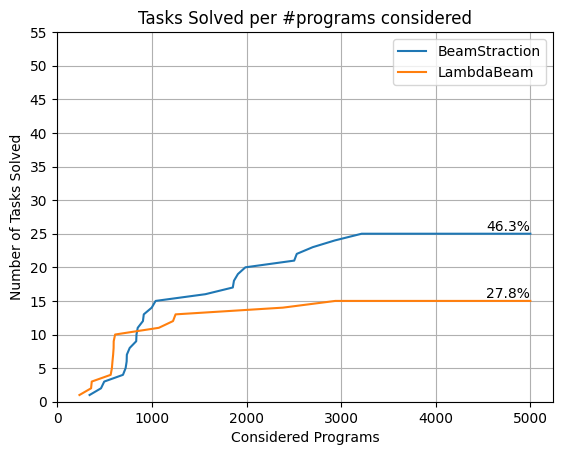

In [44]:
import matplotlib.pyplot as plt
import json

with open("/work/ldierkes/repos/new/LambdaBeam/outputs/beamstract/top/eval/results.json") as f:
    results = json.load(f)

results = results["results"]
success = []
num_programs = []
for sol in results:
    if sol["stats"]["total_num_values_explored"] < 5000:
        num_programs.append(sol["stats"]["total_num_values_explored"])
        
        success.append(sol["success"])

# Sort the data based on time taken
sorted_data = sorted(zip(num_programs, success))

# Separate the sorted data back into separate lists
sorted_time_taken, sorted_tasks_solved = zip(*sorted_data)
sorted_time_taken = tuple(list(sorted_time_taken)  + [5000])

# Calculate cumulative sum of tasks solved
cumulative_tasks = [sum(sorted_tasks_solved[:i+1]) for i in range(len(sorted_tasks_solved))]
cumulative_tasks.append(cumulative_tasks[-1])


with open("/work/ldierkes/repos/new/LambdaBeam/outputs/baseline/eval/results.json") as f:
    results = json.load(f)

results = results["results"]
success = []
num_programs = []
for sol in results:
    if sol["stats"]["total_num_values_explored"] < 5000:
        num_programs.append(sol["stats"]["total_num_values_explored"])
        
        success.append(sol["success"])

# Sort the data based on time taken
sorted_data_baseline = sorted(zip(num_programs, success))

# Separate the sorted data back into separate lists
sorted_time_taken_baseline, sorted_tasks_solved_baseline = zip(*sorted_data_baseline)
print(list(sorted_time_taken_baseline))
sorted_time_taken_baseline = tuple(list(sorted_time_taken_baseline)  + [5000])
# Calculate cumulative sum of tasks solved
cumulative_tasks_baseline = [sum(sorted_tasks_solved_baseline[:i+1]) for i in range(len(sorted_tasks_solved_baseline))]
cumulative_tasks_baseline.append(cumulative_tasks_baseline[-1])

# Plotting without markers and with legend for "BeamStraction"
plt.plot(sorted_time_taken, cumulative_tasks, linestyle='-', label='BeamStraction')
plt.plot(sorted_time_taken_baseline, cumulative_tasks_baseline, linestyle='-', label='LambdaBeam')

# Set y-axis maximum label to 54
plt.ylim(0, 54)
plt.yticks(range(0, 56, 5))


# Adding a text annotation for 50% success rate
plt.text(5000, 25, '46.3%', ha='right', va='bottom')
plt.text(5000, 15, '27.8%', ha='right', va='bottom')


plt.xlabel('Considered Programs')
plt.ylabel('Number of Tasks Solved')
plt.title('Tasks Solved per #programs considered')
plt.legend()  # Display legend
plt.grid(True)
plt.show()


In [69]:
with open("/work/ldierkes/repos/new/LambdaBeam/outputs/beamstract/top/eval/results.json") as f:
    results = json.load(f)

results = results["results"]
num_programs_with_abstraction = 0
num_programs_without_abstraction = 0
fn_counters = {}
for sol in results:
    for fn in {'fn_1', 'fn_11', 'fn_2', 'fn_26', 'fn_3', 'fn_4', 'fn_52', 'fn_6', 'fn_7'}:
        if sol["solution"] and fn in sol["solution"]:
            if fn not in fn_counters:
                fn_counters[fn] = 1
            else:
                fn_counters[fn] += 1

    for cons in [2, 3, 5]:
        if sol["solution"] and (f"{str(cons)}," in sol["solution"] or f", {str(cons)}" in sol["solution"]):
            if str(cons) not in fn_counters:
                fn_counters[str(cons)] = 1
            else:
                fn_counters[str(cons)] += 1


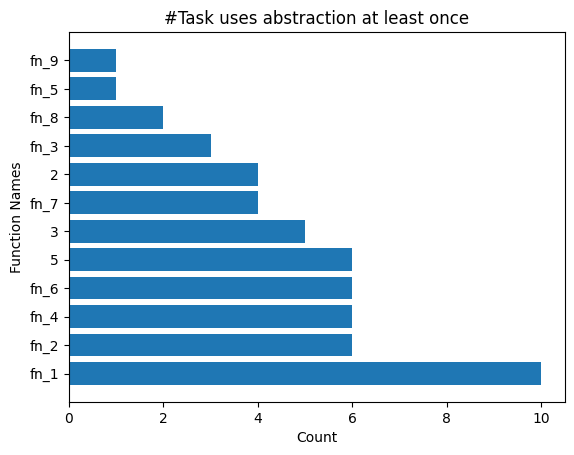

In [84]:
import matplotlib.pyplot as plt

data = {
    'fn_1': 10,
    'fn_2': 6,
    'fn_3': 3,
    'fn_4': 6,
    'fn_5': 1, # 6
    'fn_6': 6, # 7
    'fn_7': 4, # 11
    'fn_8': 2, # 26
    'fn_9': 1, # 52
    '2': 4,
    '3': 5,
    '5': 6,
    
}

# Sort the data by values in ascending order
sorted_data = dict(sorted(data.items(), key=lambda item: item[1], reverse=True))

# Extract keys and values from the sorted dictionary
labels = list(sorted_data.keys())
values = list(sorted_data.values())

# Create a horizontal bar plot
plt.barh(labels, values)

plt.xlabel('Count')
plt.ylabel('Function Names')
plt.title('#Task uses abstraction at least once')

plt.show()


In [49]:
num_programs_without_abstraction / 54

0.6666666666666666

In [48]:
num_programs_with_abstraction / 54

0.3333333333333333

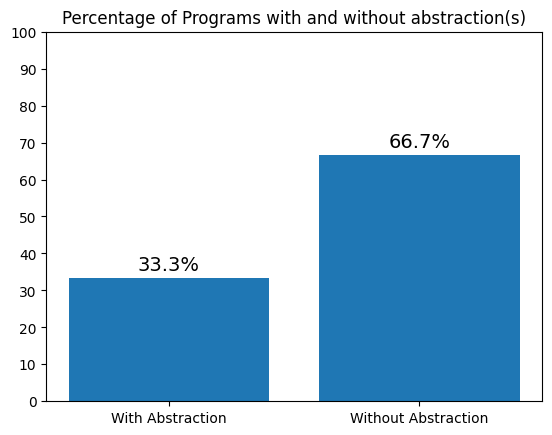

In [65]:
# Build plot for the number of programs with and without abstraction
plt.bar(["With Abstraction", "Without Abstraction"], [num_programs_with_abstraction / 54 * 100, num_programs_without_abstraction / 54 * 100])

# Add percentages on top of the bars
for i, value in enumerate([num_programs_with_abstraction, num_programs_without_abstraction]):
    percentage = value / 54 * 100
    plt.text(i, percentage + 1, f'{percentage:.1f}%', ha='center', va='bottom', fontsize=14)

plt.yticks(range(0, 101, 10))
plt.title('Percentage of Programs with and without abstraction(s)')

plt.show()